# 使用RNN来生成莎士比亚风格的句子

这个例子会用莎士比亚的著作来训练一个char-level RNN语言模型，同时使用它来生成莎士比亚风格的句子。

## 数据准备

输入文件是纯文本文件，我们会使用unidecode来把unicode转成ASCII文本。

In [11]:
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('../data/shakespeare.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 1115393


这个文件太大了，我们随机的进行截断。

In [12]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

re lay hold of him;
Bear him to the rock Tarpeian, and from thence
Into destruction cast him.

BRUTUS:
AEdiles, seize him!

Citizens:
Yield, Marcius, yield!

MENENIUS:
Hear me one word;
Beseech you, tr


## 定义模型

回忆一下之前的Char RNN 分类器，我们是“手动”实现的最朴素的RNN，现在我们使用更加先进的GRU。
另外之前是没有Embedding的，直接用字母的one-hot作为输入。

In [13]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

## 输入和输出

每个chunk会变成一个LongTensor，做法是遍历每一个字母然后把它变成all_characters里的下标。

In [14]:
# 把string变成LongTensor
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([ 10,  11,  12,  39,  40,  41])


最后我们随机的选择一个字符串作为训练数据，输入是字符串的第一个字母到倒数第二个字母，而输出是从第二个字母到最后一个字母。比如字符串是"abc"，那么输入就是"ab"，输出是"bc"

In [15]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

## 生成句子

为了评估模型生成的效果，我们首先需要让它来生成一些句子

In [16]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # 假设输入的前缀是字符串prime_str，先用它来改变隐状态
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # 根据输出概率采样
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # 用上一个输出作为下一轮的输入
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

## 训练

一些工具函数

In [17]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

训练函数：

In [18]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c:c+1])

    loss.backward()
    decoder_optimizer.step()

    return loss.item() / chunk_len

接下来我们定义训练的参数，初始化模型，开始训练：

In [19]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 9s (100 5%) 2.3245]
Whell! thhe thihe hine thy sher as, wof he's ghe liths.

OLIU:
HIO:
What hamedt juta sthithe mapnth ni 

 19s (200 10%) 2.1475]
Whode.

aor whath a mater but amt ther nourdt do in to his in for ante, wor be the thow kitake thing i 

 28s (300 15%) 2.0459]
What him besty, be
tis thou that tith thel and to say beave wourt to ilw: spearsteres ye com. entry,
W 

 37s (400 20%) 2.0369]
Whad may be his tain,
Fims in at in I prane oar not, it im
Of shim; mastruede.

CORK:
And me me san, g 

 47s (500 25%) 2.2005]
Whom mans.

Thathst sace, his perewill sold nome diest, sul. and ligule
The as aly moner
And Hadly jef 

 57s (600 30%) 1.9203]
Whath my my thour.

ThING ERDIAND:
To my cer,
And must my lentit.

GLOUCESTER:
I deast was than and be 

 6s (700 35%) 1.9028]
Whien at hepicter,
For thee corron the to hy so, we at loves, king the he mastingly his door preist, a 

 15s (800 40%) 1.9324]
Whtild that mition and on him erears flature'd for um deancue though with for that w

## 损失变化图

查看损失在训练过程中的变化有助于我们了解学习的过程。

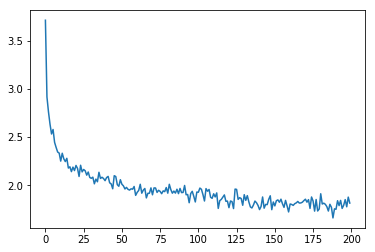

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

## 测试

In [21]:
print(evaluate('Th', 200, temperature=0.8))

There, good but, sir, in that resting may sir.

MARDANETA:
Wife, in the have his prince othere, as not;
My my pleast beir encent but thy lee the day
Wine and a isine.

FLYOMO:
My good the new:
Whol of h


In [22]:
print(evaluate('Th', 200, temperature=0.2))

There the the shall shall the shall shall the shall be the change the die a shall the shall the should that the shall shall shall be a shall the truther the chander the chander the command.

CAMILLO:
Wh
